## *Finite Element Analysis for Plane Strain Model with Topographic Profile*

This Jupyter Notebook demonstrates the application of *Finite Element Analysis (FEA)* to a structural problem with an arbitrary topographic profile. The focus is on solving the *plane strain model* using a 2D mesh generated from the topography and leveraging the *scikit-fem* library for efficient solution of the finite element equations.

### *Problem Definition:*
- Analyze the structural behavior of a component with an arbitrary topographic profile under *plane strain conditions*.
- **Objective:** Understand stress distribution and deformation patterns.

### *Workflow Overview:*
1. **Topographic Profile:** Import or generate the topographic profile representing the structure's surface.

2. **Geometry and Mesh Generation:** Convert the topographic profile into a 2D mesh suitable for the plane strain model using *pygmsh*.

3. **Material Properties:** Specify material properties relevant to the structural analysis.

4. **Boundary Conditions:** Define boundary conditions based on the structural constraints.

5. **Assembly of Global Stiffness Matrix:** Use *scikit-fem* to assemble the global stiffness matrix efficiently.

6. **Solution of the System of Equations:** Utilize *scikit-fem*'s solver to obtain nodal displacements.

### *Dependencies:*
- This notebook relies on Python libraries, including *scikit-fem*, *NumPy*, *SciPy*, and *Matplotlib*.
- Ensure that the required libraries are installed in your Python environment.

### *Reference:*

For more information about this study, please refer to the accompanying paper:

>Thiele, S.T., Zimik, H.V., Samsu, A., Akhtar, S., Kamath, A.V., Khanna, P., In Prep. Outcrop analogue constraints on subsurface reservoir properties of the Puga geothermal field, NW Himalaya. *Journal TBD*.

Please also cite this paper if our code is useful for your work. And don't hesitate to reach out if you have questions 🚀

**Author:** *Akshay Vijay Kamath*  
**Date:** *23.11.2023*

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import pygmsh
import skfem as skf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Import the inbuilt functions from skfem
from skfem.helpers import sym_grad
from skfem.models.elasticity import linear_elasticity, linear_stress, lame_parameters

In [2]:
# Import the topographic profile using pandas
df = pd.read_csv('data/topographic_profile.tsv', names=['dist', 'x','y','z'], delimiter='\\t', engine='python')

# Extract the topographic profile
# NOTE: Since the sampling of the original profile was high, every other point has been selected.
topo = np.array(df['z'])[::2]
dist = np.array(df['dist'])[::2]

# Generate nodes from profile
nodes = np.array( [(dist[0], 0)] + [(d, z) for (d,z) in zip(dist,topo)] + [(dist[-1], 0)] )

# Generate mesh with pygmsh
with pygmsh.geo.Geometry() as geom:
    poly = geom.add_polygon(nodes, mesh_size=100)
    mesh = geom.generate_mesh()

# Save the mesh as a .vtk file
mesh.write('puga.vtk')

In [3]:
# Load the saved mesh as scikit-fem mesh
SKMesh = skf.Mesh.load('puga.vtk')

# Define the left, right and bottom boundaries
SKMesh = SKMesh.with_boundaries({
    "left": lambda x: x[0] == 0,
    "right": lambda x: x[0] == max(x[0]),
    "bottom": lambda x: x[1] == 0,
})

In [4]:
# Generate the interior basis
IB = skf.InteriorBasis(SKMesh, skf.ElementVector(skf.ElementTriP1()))

# Define the clamped boundary conditions
# NOTE: The left and right boundaries are clamped in the horizontal direction and
#       the bottom boundary is clamped in the vertical direction
clamped = IB.get_dofs({"left", "right"}).nodal['u^1'] # u^1 is the x component of displacement
clamped = np.hstack([clamped, IB.get_dofs({"bottom"}).nodal['u^2']]) # u^2 is the y component of displacement

# Define material parameters
E = 5e9 # Young's modulus
nu = 0.25 # Poisson's ratio
g = 9.8 # Gravitational acceleration
rho = 2600 # Density

# Define the load function using the linear decorator in skfem
@skf.LinearForm
def load(v, w):
    return -rho * g * v.value[1] # Varies with the y coordinate

# Use inbuilt function to calculate lame's parameters from E and nu
lambda_, mu = lame_parameters(E, nu)

# Create a global stiffness matrix mapped onto the interior basis
K = skf.asm(linear_elasticity(lambda_, mu), IB)

# Generate the external load vector
f = skf.asm(load, IB)

# Solve the system for displacements
u = skf.solve(*skf.condense(K, f, D=clamped))

# Generate the deformed mesh by adding the displacements to the original mesh
SKMesh_Deformed = skf.MeshTri1(SKMesh.p + u[IB.nodal_dofs], SKMesh.t)

Transforming over 1000 vertices to C_CONTIGUOUS.


In [5]:
# Interpolate the displacements onto the interior basis
y = IB.interpolate(u)

# Generate a new interior basis with the same mesh but with a higher order element
SIB = IB.with_element(skf.ElementVectorH1(skf.ElementVectorH1(skf.ElementTriP1())))

# Define the stiffness matrix for the higher order basis
C = linear_stress(lambda_, mu)

# Calculate the stress tensor using the gradient of the displacements
sigma = SIB.project(C(sym_grad(y)))

# Calculate the Z-Component of the stress using Poisson's relation
sigmaZ = nu * (sigma[SIB.nodal_dofs[0]] + sigma[SIB.nodal_dofs[3]])

# Negating the stress values to honor the convention used in geosciences
sigmaX = -sigma[SIB.nodal_dofs[0]]
sigmaY = -sigma[SIB.nodal_dofs[3]]
sigmaXY = -sigma[SIB.nodal_dofs[1]]
sigmaZ = -sigmaZ

# Define the 2D stress tensor
Sigma = np.array([
    [sigmaX, sigmaXY],
    [sigmaXY, sigmaY]
    ])

# Calculate the eigenvalues and eigenvectors of the stress tensor for the principal stresses
for i in range(np.shape(Sigma)[2]):
    eval, evec = np.linalg.eig(Sigma[:,:,i])

    idx = eval.argsort()[::-1]
    eval = eval[idx]
    evec = evec[:,idx]

    if i == 0:
        eigval = eval
        eigvec = evec.flatten()
    else:
        eigval = np.vstack((eigval, eval))
        eigvec = np.vstack((eigvec, evec.flatten()))

# Extract the directions
sigmaMaxDir = eigvec[:,0:2]
sigmaMinDir = eigvec[:,2:4]

In [6]:
# First Invariant (Trace of stress tensor)
I1 = sigmaX + sigmaY + sigmaZ 
# Second invariant
J2 = (((sigmaY - sigmaZ) ** 2 + (sigmaZ - sigmaX) ** 2 + (sigmaX - sigmaY) ** 2)/6) + sigmaXY ** 2

# Initialize the parameters for calculating the Drucker-Prager stability factor
fric = 0.8
Cohe = 0.75e6
# Alpha and kappa parameters for the stability factor
alpha = fric / np.sqrt(9 + 12 * (fric ** 2))
kappa = 3 * Cohe / np.sqrt(9 + 12 * (fric ** 2))
# Drucker-Prager Stability Factor
FDP = (alpha * I1 + kappa) / (np.sqrt(J2))

# Angle of deviation of sigma1 from vertical (in rad)
Theta = np.arctan(sigmaMaxDir[:,0]/sigmaMaxDir[:,1])

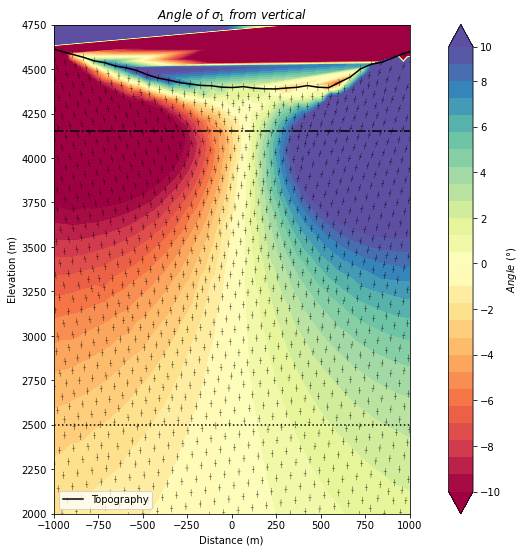

In [7]:
# Plotting the results
# 1.) Angle of deviation of sigma-1 from vertical
fig, ax = plt.subplots(figsize=(14,9))
# Plotting topography
ax.plot(dist - 11500, topo, 'k')
# Plotting a tricontourf() plot with the angles of deviation (in degrees)
# NOTE: The shifting in x has been done to center the plot at the area of interest.
cntr = ax.tricontourf(SKMesh.p[0,:] - 11500, SKMesh.p[1,:], Theta * 180/(np.pi), np.arange(-10, 10, 0.75), cmap="Spectral", extend="both")
cbar = plt.colorbar(cntr)
cbar.set_label('$Angle\ (\degree)$')
cbar.set_ticks(np.arange(-10, 12, 2))
# Plot the stress ticks using a quiver plot
plt.quiver(SKMesh.p[0,:] - 11500, SKMesh.p[1,:], sigmaMaxDir[:,0], sigmaMaxDir[:,1], color='k', width=0.001, headwidth=0, headlength=0, headaxislength=0, scale=50, pivot="mid")
plt.quiver(SKMesh.p[0,:] - 11500, SKMesh.p[1,:], sigmaMinDir[:,0], sigmaMinDir[:,1], color='k', width=0.001, headwidth=0, headlength=0, headaxislength=0, scale=120, pivot="mid")
# Set axis limits and labels
plt.xlim([-1000, 1000])
plt.ylim([2000, 4750])
plt.xticks(np.arange(-1000, 1250, 250))
plt.yticks(np.arange(2000, 4800, 250))
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.title(r'$Angle\ of\ \sigma_{1}\ from\ vertical$')
plt.legend(['Topography'], loc="lower left")
plt.gca().set_aspect('equal')
# Mark lines at approximate depths for reservoir of interest (according to the values given by FDP)
plt.hlines(4150, -1000, 1000, 'k', linestyles='dashdot')
plt.hlines(2500, -1000, 1000, 'k', linestyles='dotted')
# plt.savefig('AngleOfDeviation.svg', dpi=300, bbox_inches='tight')
plt.show()

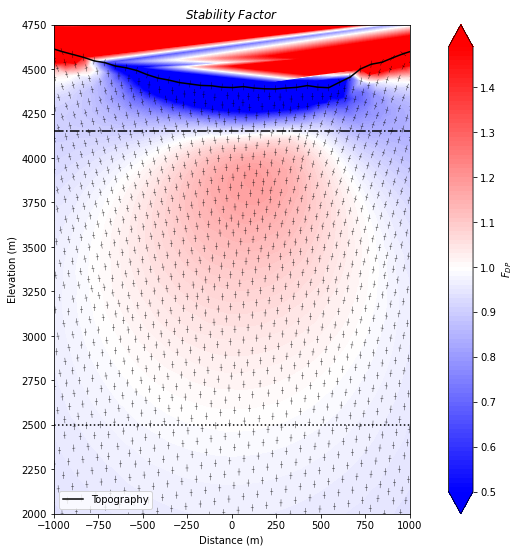

In [8]:
# Plotting the results
# 1.) Stability Factor
fig, ax = plt.subplots(figsize=(14,9))
# Plotting topography
ax.plot(dist - 11500, topo, 'k')
# Plotting a tricontourf() plot with the FDP values
# NOTE: The shifting in x has been done to center the plot at the area of interest.
cntr = ax.tricontourf(SKMesh.p[0,:] - 11500, SKMesh.p[1,:], FDP, np.arange(0.5, 1.5, 0.01), cmap="bwr", extend="both")
cbar = plt.colorbar(cntr)
cbar.set_label('$F_{DP}$')
# Plot the stress ticks using a quiver plot
plt.quiver(SKMesh.p[0,:] - 11500, SKMesh.p[1,:], sigmaMaxDir[:,0], sigmaMaxDir[:,1], color='k', width=0.001, headwidth=0, headlength=0, headaxislength=0, scale=50, pivot="mid")
plt.quiver(SKMesh.p[0,:] - 11500, SKMesh.p[1,:], sigmaMinDir[:,0], sigmaMinDir[:,1], color='k', width=0.001, headwidth=0, headlength=0, headaxislength=0, scale=120, pivot="mid")
# Set axis limits and labels
plt.xlim([-1000, 1000])
plt.ylim([2000, 4750])
plt.xticks(np.arange(-1000, 1250, 250))
plt.yticks(np.arange(2000, 4800, 250))
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.title(r'$Stability\ Factor$')
plt.legend(['Topography'], loc="lower left")
plt.gca().set_aspect('equal')
# Mark lines at approximate depths for reservoir of interest (according to the values given by FDP)
plt.hlines(4150, -1000, 1000, 'k', linestyles='dashdot')
plt.hlines(2500, -1000, 1000, 'k', linestyles='dotted')
# plt.savefig('StabilityFactor.svg', dpi=300, bbox_inches='tight')
plt.show()